# Flower Recognition

## Implement Deep Learning to recognise kind of flower (daisy, dandelion, rose, sunflower, tulip) in an image uploaded to Web app

### Get data

In [1]:
import numpy as np
import os
import pathlib
import random
import PIL
import PIL.Image

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
print(tf.__version__)

2.4.1


Downloads a file from a URL if it not already in the cache. The final location of a file
`example.txt` would be `~/.keras/datasets/example.txt`.

/Users/anja.jesierski/.keras/datasets/flower_photos

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


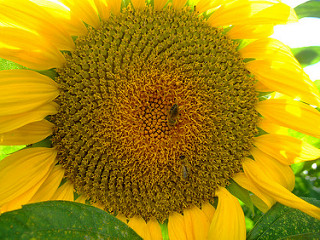

In [5]:
sunflowers = list(data_dir.glob('sunflowers/*')) 
PIL.Image.open(str(sunflowers[7]))

### Data preprocessing

In [3]:
batch_size = 32
img_height = 180
img_width = 180

#### Use 80% of the images for training, and 20% for validation.

In [14]:
X_train = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [15]:
X_test = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [9]:
2936 + 734

3670

In [6]:
class_names = X_train.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [11]:
X_train

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

### Visualise the data

In [12]:
type(X_train.take(1))

tensorflow.python.data.ops.dataset_ops.TakeDataset

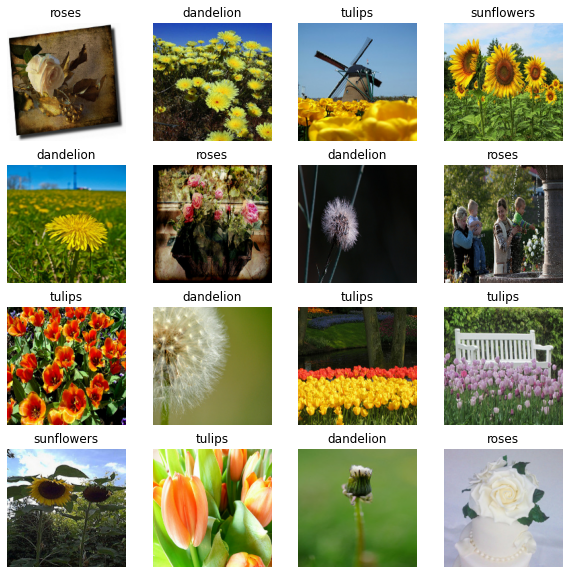

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in X_train.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in X_train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension referes to color channels RGB). The `labels_batch` is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Note: you can call `.numpy()` on either of these tensors to convert them to a `numpy.ndarray`.

#### Normalisation

RGB channel values are in the [0, 255] range. Normalise them to be in interval [0,1] for better performance later in deep learning model.

Include the layer from `tf.keras.layers.experimental.preprocessing.Rescaling(1./255)` inside your model definition to simplify deployment. 

#### Configure the dataset for performance
Let us make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking.

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

X_train = X_train.cache().prefetch(buffer_size=AUTOTUNE)
X_test = X_test.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
num_classes = 5

model_a = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, activation='sigmoid'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='sigmoid'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='sigmoid'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='sigmoid'),
  layers.Dense(num_classes, activation='softmax')
])

In [22]:
model_a.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [23]:
model_a.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 41, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 20, 20, 32)       

In [24]:
epochs = 3
history = model_a.fit(
  X_train,
  validation_data=X_test,
  epochs=epochs
)

Epoch 1/3
92/92 [==============================] - 102s 1s/step - loss: 2.4724 - accuracy: 0.2464 - val_loss: 1.6003 - val_accuracy: 0.2459
Epoch 2/3
92/92 [==============================] - 101s 1s/step - loss: 1.5973 - accuracy: 0.2567 - val_loss: 1.6007 - val_accuracy: 0.2459
Epoch 3/3
92/92 [==============================] - 78s 848ms/step - loss: 1.5982 - accuracy: 0.2567 - val_loss: 1.6008 - val_accuracy: 0.2459


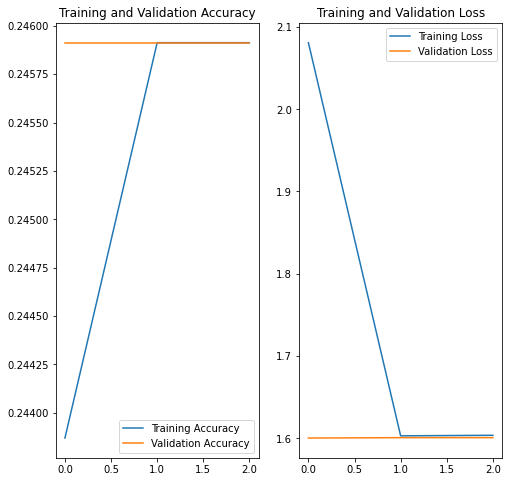

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Even just 3 epochs show signs of overtfitting.**

In [39]:
model_a.save('models/model_a')

INFO:tensorflow:Assets written to: models/model_a/assets


In [40]:
loaded_model = keras.models.load_model('models/model_a')

### Predict testwise

In [41]:
path = pathlib.Path('data')
image_count = len(list(path.glob('*/*.jpeg')))
print(image_count)

35


5 x 7 flower photos randomly selected from the internet manually

In [33]:
path_ex = pathlib.Path(random.choice(list(path.glob('*/*.jpeg'))))
str(path_ex)

'data/sunflowers/sunflower7.jpeg'

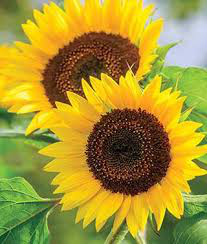

In [34]:
img = PIL.Image.open(path_ex)
img

Make picture shape (180x180x3) to be fed into model

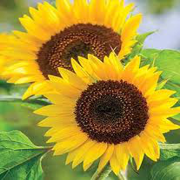

In [35]:
img = img.resize((180,180))
img

In [36]:
#img_array = image.img_to_array(img.resize((180,180))).astype(np.uint8)
img_array = image.img_to_array(img)
img_array.shape

(180, 180, 3)

Need one batch of 32 pictures to feed into the odel. Expected shape (32,180,180,3)

In [37]:
img_array = tf.expand_dims(img_array, 0) # Create a batch
img_array.shape

TensorShape([1, 180, 180, 3])

In [42]:
predictions = loaded_model.predict(img_array)
predictions.sum()

0.99999994

In [43]:
score = predictions[0]

result="This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))
result

'This image most likely belongs to dandelion with a 23.57 percent confidence.'

In [44]:
predictions

array([[0.16819404, 0.23571469, 0.19337918, 0.18146849, 0.22124355]],
      dtype=float32)

In [45]:
loaded_model.predict(img_array)

array([[0.16819404, 0.23571469, 0.19337918, 0.18146849, 0.22124355]],
      dtype=float32)

## Improve model

Data Augmentation to avoid overfitting

In [16]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip('horizontal', 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

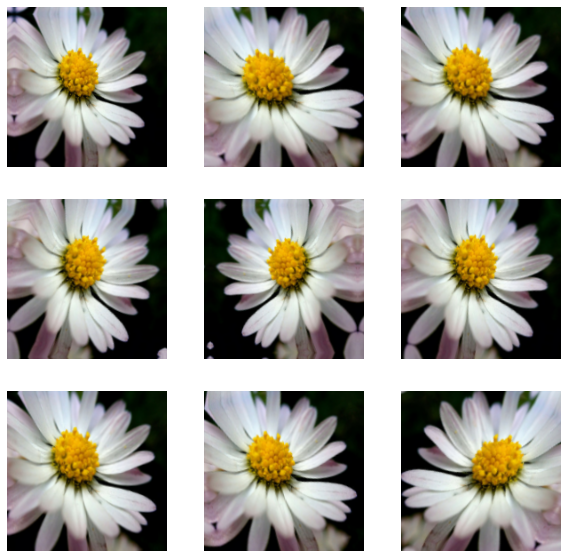

In [47]:
plt.figure(figsize=(10, 10))
for images, _ in X_train.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Dropout included

In [17]:
num_classes = 5

model_b = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

In [18]:
model_b.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [19]:
model_b.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [12]:
callback = EarlyStopping(monitor='val_loss', patience=3)

In [59]:
epochs = 50

history_b = model_b.fit(
  X_train,
  validation_data=X_test,
  epochs=epochs,
  callbacks=[callback]
)

Epoch 1/50
92/92 [==============================] - 64s 684ms/step - loss: 1.5619 - accuracy: 0.3075 - val_loss: 1.1343 - val_accuracy: 0.5099
Epoch 2/50
92/92 [==============================] - 68s 738ms/step - loss: 1.0839 - accuracy: 0.5559 - val_loss: 1.0741 - val_accuracy: 0.5957
Epoch 3/50
92/92 [==============================] - 69s 754ms/step - loss: 0.9745 - accuracy: 0.6183 - val_loss: 0.9889 - val_accuracy: 0.6301
Epoch 4/50
92/92 [==============================] - 64s 695ms/step - loss: 0.9080 - accuracy: 0.6391 - val_loss: 0.8231 - val_accuracy: 0.6921
Epoch 5/50
92/92 [==============================] - 66s 719ms/step - loss: 0.8365 - accuracy: 0.6761 - val_loss: 0.8260 - val_accuracy: 0.6914
Epoch 6/50
92/92 [==============================] - 64s 698ms/step - loss: 0.8077 - accuracy: 0.6872 - val_loss: 0.8012 - val_accuracy: 0.7064
Epoch 7/50
92/92 [==============================] - 64s 697ms/step - loss: 0.7720 - accuracy: 0.7064 - val_loss: 0.7909 - val_accuracy: 0.7166

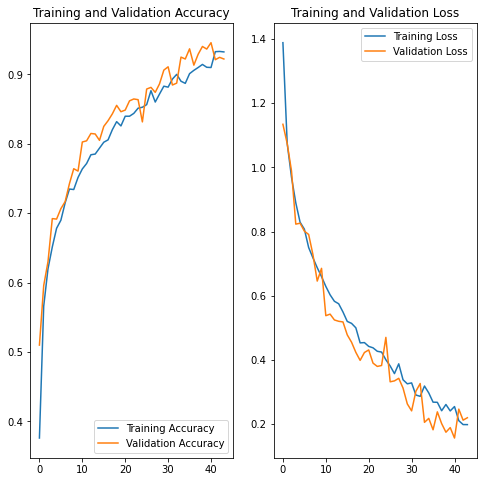

In [60]:
epochs = 44

acc = history_b.history['accuracy']
val_acc = history_b.history['val_accuracy']

loss = history_b.history['loss']
val_loss = history_b.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
epochs = 41

history_b = model_b.fit(
  X_train,
  validation_data=X_test,
  epochs=epochs,
  callbacks=[callback]
)

Epoch 1/41
92/92 [==============================] - 82s 856ms/step - loss: 1.5575 - accuracy: 0.3052 - val_loss: 1.0448 - val_accuracy: 0.5732
Epoch 2/41
92/92 [==============================] - 73s 790ms/step - loss: 1.0203 - accuracy: 0.5948 - val_loss: 0.9971 - val_accuracy: 0.6206
Epoch 3/41
92/92 [==============================] - 73s 787ms/step - loss: 0.9254 - accuracy: 0.6508 - val_loss: 0.9001 - val_accuracy: 0.6676
Epoch 4/41
92/92 [==============================] - 73s 791ms/step - loss: 0.8713 - accuracy: 0.6657 - val_loss: 0.7956 - val_accuracy: 0.6938
Epoch 5/41
92/92 [==============================] - 72s 784ms/step - loss: 0.7945 - accuracy: 0.6981 - val_loss: 0.8308 - val_accuracy: 0.6897
Epoch 6/41
92/92 [==============================] - 74s 802ms/step - loss: 0.7869 - accuracy: 0.7064 - val_loss: 0.7135 - val_accuracy: 0.7371
Epoch 7/41
92/92 [==============================] - 75s 809ms/step - loss: 0.7306 - accuracy: 0.7149 - val_loss: 0.8176 - val_accuracy: 0.6849

In [21]:
model_b.save('models/model_b')

INFO:tensorflow:Assets written to: models/model_b/assets
